# A/B experiment analysis

Так как у меня при запуке эксперимента не добавлялось поле treatment в логи (я так и не разобралась почему?), то я отдельно запускала 2 экперимента: 1 только для нейросетевого рекомендера с последнего семинара ("С") и второй для своего рекомендера ("Т"). Потом конкатенировала таблицы и делала анализ

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

pd.set_option("display.precision", 3)

%matplotlib inline

#Результаты эксперимента с моим рекомендером

In [3]:
data_my_1 = pd.read_json("/content/drive/MyDrive/MADE/REC_SYS/rec_model1/my_recs_v4.json", lines=True)
data_my_1.shape

(10927, 8)

#Результаты эксперимента с нейросетевым рекомендером из последнего семинара

In [4]:
data_C = pd.read_json("/content/drive/MyDrive/MADE/REC_SYS/rec_model1/contextual_exp.json", lines=True)
data_C.shape

(10214, 8)

In [5]:
print(len(np.unique(data_my_1['user'])))
data_my_1['treatment'] = ['T1' for i in range(data_my_1.shape[0])]
data_my_1.head()

951


,message,timestamp,user,track,time,latency,recommendation,experiments,treatment
0,next,2023-04-09 07:46:30.926,3255,2659,1.0,1.005e-03,442.0,{},T1
1,next,2023-04-09 07:46:30.936,3255,442,1.0,5.770e-04,420.0,{},T1
2,next,2023-04-09 07:46:30.943,3255,420,1.0,7.207e-04,1507.0,{},T1
3,next,2023-04-09 07:46:30.951,3255,1507,1.0,8.018e-04,2640.0,{},T1
4,next,2023-04-09 07:46:30.959,3255,2640,1.0,6.599e-04,159.0,{},T1


In [6]:
print(len(np.unique(data_C['user'])))
data_C['treatment'] = ['C' for i in range(data_C.shape[0])]
data_C.head()

952


,message,timestamp,user,track,time,latency,recommendation,experiments,treatment
0,next,2023-04-03 12:39:02.619,3255,2659,1.00,7.681e-03,1995.0,{},C
1,next,2023-04-03 12:39:02.680,3255,1995,1.00,7.176e-04,6615.0,{},C
2,next,2023-04-03 12:39:02.691,3255,6615,0.93,8.931e-04,1987.0,{},C
3,next,2023-04-03 12:39:02.700,3255,1987,0.65,1.109e-03,8441.0,{},C
4,next,2023-04-03 12:39:02.708,3255,8441,0.38,8.879e-04,4632.0,{},C


In [9]:
data = pd.concat([data_C, data_my_1])
data.shape

(21141, 9)

## Visualize sessions

In [10]:
Session = namedtuple("Session", ["timestamp", "tracks", "time", "latency"])

def sessionize(user_data):
    sessions = []
    session = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if session is None:
            session = Session(row["timestamp"], 0, 0, 0)
        
        session = session._replace(
            tracks = session.tracks + 1, 
            time = session.time + row["time"],
            latency = session.latency + row["latency"] * 1000,
        )
        
        if row["message"] == "last":
            sessions.append(session._asdict())
            session = None
    return sessions

In [11]:
sessions = (
    data
    .groupby(["user", "treatment"])
    .apply(sessionize)
    .explode()
    .apply(pd.Series)
)

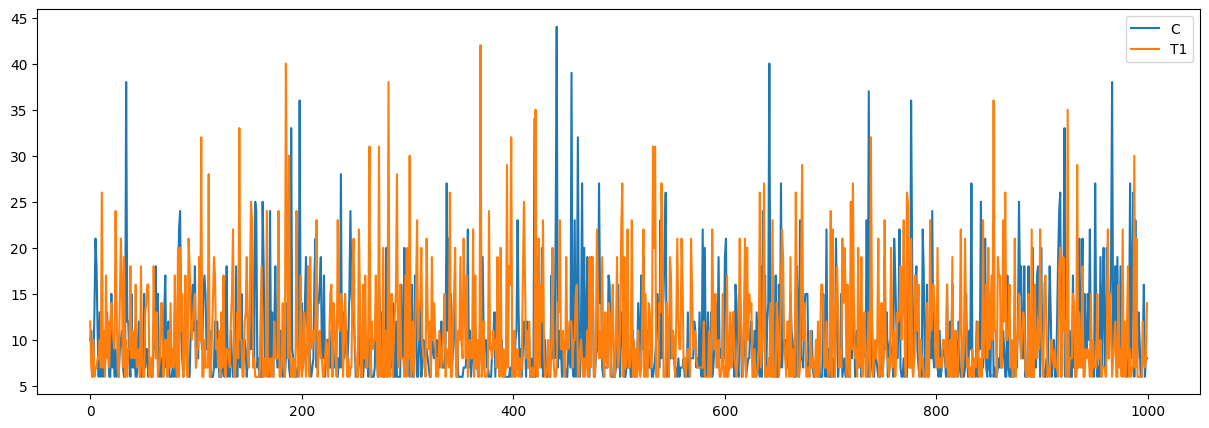

In [12]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["tracks"], label=treatment)
ax.legend()
pass

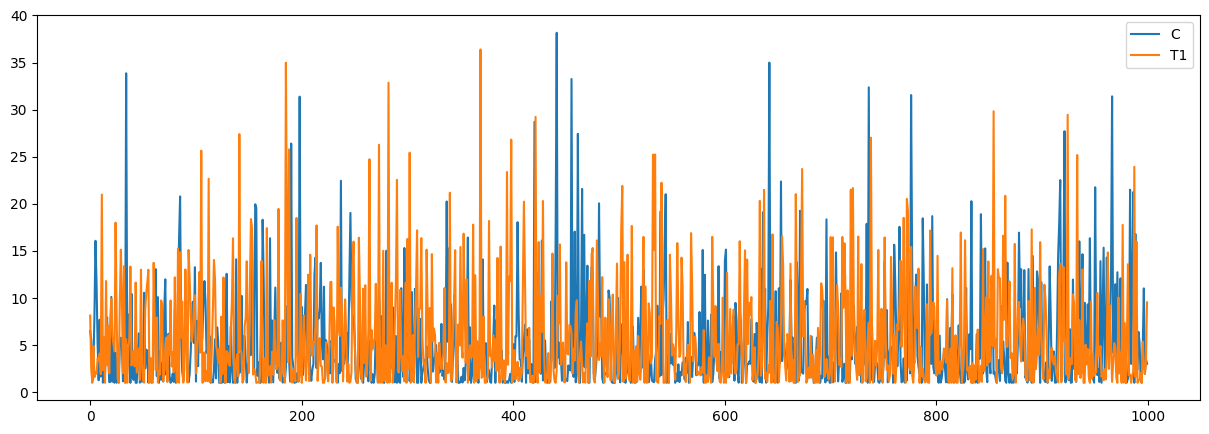

In [13]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["time"], label=treatment)
ax.legend()
pass

## Analyze the experiment

In [14]:
user_level_data = (
  sessions
    .reset_index()
    .groupby(["user", "treatment"])
    .agg(
        {
            "timestamp": "count",
            "tracks": "sum",
            "time": "sum",
            "latency": "sum"
        }
    )
)

user_level_data["sessions"] = user_level_data["timestamp"]
user_level_data["mean_request_latency"] = user_level_data["latency"] / user_level_data["tracks"]
user_level_data["mean_tracks_per_session"] = user_level_data["tracks"] / user_level_data["sessions"]
user_level_data["mean_time_per_session"] = user_level_data["time"] / user_level_data["sessions"]

metrics = [
    "time", 
    "sessions", 
    "mean_request_latency", 
    "mean_tracks_per_session", 
    "mean_time_per_session"
]

user_level_metrics = user_level_data[metrics].copy().reset_index()

In [15]:
treatment_level_metrics = (
    user_level_metrics
    .groupby("treatment")[metrics]
    .agg(["count", "mean", "var"])
)

In [16]:
def dof(n_0, n_1, s2_0, s2_1):
    numerator = (s2_0 / n_0 + s2_1 / n_1) * (s2_0 / n_0 + s2_1 / n_1)
    denominator = s2_0 * s2_0 / n_0 / n_0 / (n_0 - 1) + s2_1 * s2_1 / n_1 / n_1 / (n_1 - 1)
    return numerator / denominator


def ci(n_0, n_1, s2_0, s2_1, alpha=0.05):
    return ss.t.ppf(1 - alpha/2, dof(n_0, n_1, s2_0, s2_1)) * np.sqrt(s2_0 / n_0 + s2_1 / n_1)


effects = []

control = [data for treatment, data in treatment_level_metrics.iterrows() if treatment == "C"][0]

for treatment, row in treatment_level_metrics.iterrows():
    if treatment == "C":
        continue
    
    for metric in metrics:
        control_mean = control[metric]["mean"]
        treatment_mean = row[metric]["mean"]
        
        effect = treatment_mean - control_mean
        conf_int = ci(
            control[metric]["count"],
            row[metric]["count"],
            control[metric]["var"],
            row[metric]["var"],
        )
        print(metric, effect, conf_int)
        effects.append({
            "treatment": treatment,
            "metric": metric,
            "control_mean": control_mean,
            "treatment_mean": treatment_mean,
            "effect": effect / control_mean * 100,
            "lower": (effect - conf_int) / control_mean * 100,
            "upper": (effect + conf_int) / control_mean * 100,
            "significant": (effect + conf_int) * (effect - conf_int) > 0
        })

time 0.8015828760526293 0.5386901389503702
sessions 0.0011045427634774896 0.02000013764811846
mean_request_latency -0.3119108414023619 0.06742528641896729
mean_tracks_per_session 0.6260730632947169 0.5104351893122839
mean_time_per_session 0.6714678489692405 0.4996881798640798


In [17]:
def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,14.774863,24.704058,4.845668,5.425315,6.226898,True
1,T1,sessions,0.105152,2.009166,-1.798861,1.050420,1.051525,False
3,T1,mean_tracks_per_session,6.120679,11.110848,1.130511,10.228817,10.854890,True
4,T1,mean_time_per_session,12.964558,22.612430,3.316685,5.179258,5.850726,True
2,T1,mean_request_latency,-24.107444,-18.896175,-29.318713,1.293836,0.981925,True
